# **1. Import Packages**

In [1]:
import re
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling1D, Embedding, Conv1D, LSTM, GRU, Dense, Dropout, Activation, Bidirectional
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import pandas as pd
pd.options.display.max_colwidth = None
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

# !pip install qalsadi
# import qalsadi.lemmatizer

!pip install Tashaphyne
from tashaphyne.stemming import ArabicLightStemmer

!pip install langdetect
!pip install polyglot
!pip install pyicu
!pip install pycld2
from polyglot.detect import Detector
from langdetect import detect

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 5.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 4.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=e23625bd3c1b0f3bc4f6c776338d76266564439c4c425c6cbecbb913e94efd3c
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.0/260.0 kB 2.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel fo

# **2. Data Exploration**

 # 2.1. Read Data

In [2]:
df =  pd.read_csv("/kaggle/input/arabic-company-reviews/CompanyReviews.csv")

In [3]:
df.rename(columns={'rating': 'actual_ratings'}, inplace=True)

In [4]:
df.head(9)

,Unnamed: 0,review_description,actual_ratings,company
0,0,رائع,1,talbat
1,1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشكل اسرع,1,talbat
2,2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال بالشبكة..مع انه النت عندي تمام شو الحل??,-1,talbat
3,3,لماذا لا يمكننا طلب من ماكدونالدز؟,-1,talbat
4,4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكون فاتحه بقاله كده اكتر من شهر,-1,talbat
5,5,أصبح غالي جداً,-1,talbat
6,6,جميل جدا رائع. . .,1,talbat
7,7,للأسف الواحد ينصدم بعد زيادة الاسعار و للاسف بعض المطاعم اصبحت معاملتهم رديئة,-1,talbat
8,8,برنامج توترز توصيل احلى من برنامجكم فاشل,-1,talbat


# 2.2. Distribution of Ratings 

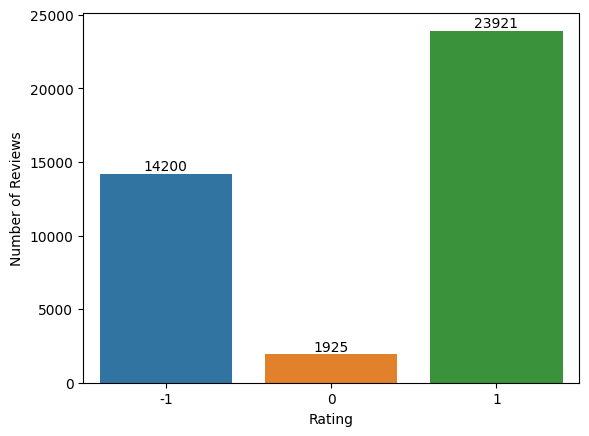

In [5]:
sns.countplot(x=df['actual_ratings'], data=df)
plt.ylabel("Number of Reviews")

value_counts = df['actual_ratings'].value_counts().sort_index()

for i, count in enumerate(value_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xlabel("Rating")  
plt.show()

# **3. Text Preprocessing**

# 3.1. Drop Unnecessary Columns

In [6]:
df = df.drop(columns=['Unnamed: 0', 'company'])

# 3.2. Drop Null Values

In [7]:
df.dropna(subset=['review_description'], inplace=True)

# 3.3. Delete Non-Arabic Reviews

In [8]:
df['review_description'] = df['review_description'].str.replace(r'[^\u0600-\u06FF\s]+', '', regex=True)

df = df[df['review_description'].apply(lambda text: Detector(str(text), quiet=True).language.code == 'ar')]

# 3.4. Delete Arabic Stop Words

In [9]:
!git clone https://github.com/mohataher/arabic-stop-words.git
    
with open('/kaggle/working/arabic-stop-words/list.txt', 'r') as file:
    stop_words = file.read().splitlines()

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df['review_description'] = df['review_description'].apply(lambda x: remove_stopwords(x))

Cloning into 'arabic-stop-words'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 42 (delta 0), reused 3 (delta 0), pack-reused 37
Receiving objects: 100% (42/42), 23.24 KiB | 3.32 MiB/s, done.
Resolving deltas: 100% (17/17), done.


# 3.5. Remove Punctuation, Special Characters, Extra Spaces and Numbers

In [10]:
df['review_description'] = df['review_description'].str.replace('[{}{}]'.format(string.punctuation,' َ ً ُ ٌ ِ ٍ ْ ÷ے،ہ؛؟«¿?»ـζ'), ' ', regex=True).str.replace(r'[\s\d]+', ' ', regex=True)

# 3.6. Remove Diacritics

In [11]:
df['review_description'] = df['review_description'].str.replace("آ", "ا") \
    .str.replace("إ", "ا") \
    .str.replace("أ", "ا") \
    .str.replace("ٱ", "ا") \
    .str.replace("لإ", "لا") \
    .str.replace("لأ", "لا") \
    .str.replace("لآ", "لا") \
    .str.replace("لأ", "لا") \
    .str.replace("لأ", "لا") \
    .str.replace("ؤ", "و") \
    .str.replace("ۆ", "و") \
    .str.replace("ڑ", "ر") \
    .str.replace("ئ", "ي") \
    .str.replace("ة", "ه") \
    .str.replace("گ", "ك") \
    .str.replace("ک", "ك") \
    .str.replace("چ", "ج") \
    .str.replace("څ", "خ") \
    .str.replace("ڤ", "ف") \
    .str.replace("ظ", "ض") \




# 3.7. Remove Repeated Characters

In [12]:
df['review_description'] = df['review_description'].apply(lambda x: re.sub(r'(.)\1+', r'\1', x))

# 3.8. Remove Kashida ( الـــتـــطـــويـــل )

In [13]:
df['review_description'] = df['review_description'].apply(lambda x: re.sub(r'ـ', '', x))

# 3.9. Remove Reviews with Less Than 2 Letters

In [14]:
df = df[df['review_description'].str.len() >= 2]

# 3.10. Stemming

In [15]:
ArListem = ArabicLightStemmer()
df['review_description'] = df['review_description'].apply(lambda x : " ".join([ArabicLightStemmer().light_stem(word) for word in x.split()]))

# 3.11. Final Data

In [16]:
df.head(9)

,review_description,actual_ratings
0,رايع,1
1,رنامج رايع ساعد لب احتياج سرع,1
2,تطبيق يغتح دايم يعطين وجد تصال شبكهمع نت عند مام شو حل,-1
3,مك طلب ماكدونالدز,-1
4,برنامج يضهر مطاعم مغلق تكون تح قال ده كتر شهر,-1
5,غال جد,-1
6,جميل رايع,1
7,اسف واحد ينصدم زياد اسعار اسف مطاعم اصبح معامل رد,-1
8,رنامج وترز وصيل حلى رنامج شل,-1


In [17]:
df.shape

(36647, 2)

# **4. Building Models**

# **4.1 Prepare Models**

# 4.1.1. Split Data

In [18]:
x_train, x_test, y_train, y_test = train_test_split(
  df['review_description'], df['actual_ratings'], test_size=0.2 , random_state=42)

# 4.1.2. Label Encoding

In [19]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 4.1.3. Tokenization

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

# 4.1.4. Padding Sequences

In [21]:
max_sequence_length = max(len(seq) for seq in df['review_description'])
x_train_padded = pad_sequences(x_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# 4.1.5. One-Hot Encoding

In [22]:
y_train_encoded = to_categorical(y_train_encoded, num_classes=3)
y_test_encoded = to_categorical(y_test_encoded, num_classes=3)

# 4.2. **Building LSTM Model**

# 4.2.1. LSTM Model Structure

In [23]:
lstm = Sequential()
lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length))
lstm.add(Bidirectional(LSTM(64)))
lstm.add(Dense(64, activation='tanh'))
lstm.add(Dense(32, activation='tanh'))
lstm.add(Dense(3, activation='softmax'))

# 4.2.2. Model Summary

In [24]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1423, 128)         1833216   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1942467 (7.41 MB)
Trainable params: 1942467 (7.41 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

# 4.2.3. Model Compilation

In [25]:
lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4.2.4. Model Training

In [26]:
lstm.fit(x_train_padded, y_train_encoded, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
367/367 [==============================] - 72s 172ms/step - loss: 0.5112 - accuracy: 0.8033 - val_loss: 0.4637 - val_accuracy: 0.8298
Epoch 2/5
367/367 [==============================] - 39s 107ms/step - loss: 0.3721 - accuracy: 0.8659 - val_loss: 0.4756 - val_accuracy: 0.8291
Epoch 3/5
367/367 [==============================] - 37s 100ms/step - loss: 0.3036 - accuracy: 0.8932 - val_loss: 0.5257 - val_accuracy: 0.8165
Epoch 4/5
367/367 [==============================] - 37s 101ms/step - loss: 0.2490 - accuracy: 0.9143 - val_loss: 0.5526 - val_accuracy: 0.8168
Epoch 5/5
367/367 [==============================] - 34s 92ms/step - loss: 0.2112 - accuracy: 0.9287 - val_loss: 0.6157 - val_accuracy: 0.7993


# **4.3. Building GRU Model**

# 4.3.1. GRU Model Structure

In [27]:
gru = Sequential()
gru.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length))
gru.add(Bidirectional(GRU(64)))
gru.add(Dense(64, activation='tanh'))
gru.add(Dense(32, activation='tanh'))
gru.add(Dense(3, activation='softmax'))

# 4.3.2. Model Summary

In [28]:
gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1423, 128)         1833216   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1918147 (7.32 MB)
Trainable params: 1918147 (7.32 MB)
Non-trainable params: 0 (0.00 Byte)
________________

# 4.3.3. Model Compilation

In [29]:
gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4.3.4. Model Training

In [30]:
gru.fit(x_train_padded, y_train_encoded, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
367/367 [==============================] - 59s 148ms/step - loss: 0.5067 - accuracy: 0.8068 - val_loss: 0.4542 - val_accuracy: 0.8353
Epoch 2/5
367/367 [==============================] - 37s 100ms/step - loss: 0.3717 - accuracy: 0.8666 - val_loss: 0.4736 - val_accuracy: 0.8308
Epoch 3/5
367/367 [==============================] - 35s 96ms/step - loss: 0.3003 - accuracy: 0.8945 - val_loss: 0.5130 - val_accuracy: 0.8267
Epoch 4/5
367/367 [==============================] - 33s 91ms/step - loss: 0.2496 - accuracy: 0.9149 - val_loss: 0.5689 - val_accuracy: 0.8017
Epoch 5/5
367/367 [==============================] - 34s 92ms/step - loss: 0.2128 - accuracy: 0.9298 - val_loss: 0.6112 - val_accuracy: 0.8054


# **4.4. Model Prediction**
Select random samples from the test data and apply the prediction

# 4.4.1 Select Random Samples

In [31]:
random_indices = np.random.choice(len(x_test), size=30, replace=False)
sample_texts = [str(x_test.iloc[i]) for i in random_indices]
sample_actual_ratings = [y_test.iloc[i] for i in random_indices]
sample_encoded_actual_ratings = [y_test_encoded[i] for i in random_indices]

sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_padded = pad_sequences(sample_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# 4.4.2. LSTM Prediction

In [32]:
lstm_sample_predicted_ratings = lstm.predict(sample_padded)
lstm_sample_predicted_classes = [label_encoder.inverse_transform([np.argmax(score)])[0] for score in lstm_sample_predicted_ratings]

1/1 [==============================] - 1s 777ms/step


# 4.4.3. GRU Prediction

In [33]:
gru_sample_predicted_ratings = gru.predict(sample_padded)
gru_sample_predicted_classes = [label_encoder.inverse_transform([np.argmax(score)])[0] for score in gru_sample_predicted_ratings]

1/1 [==============================] - 1s 637ms/step


# 4.4.4. Prediction Results

In [34]:
results_df = pd.DataFrame({
    'Sample Text': sample_texts,
    'Actual Rating': sample_actual_ratings,
    'LSTM Rating': lstm_sample_predicted_classes,
    'GRU Rating': gru_sample_predicted_classes,
})

results_df

,Sample Text,Actual Rating,LSTM Rating,GRU Rating
0,زبل قيم طلب يتاخر سع لغي اردر قول مش متاح طيار نصح عدم تطبيق,-1,-1,-1
1,حل,1,1,1
2,طبيق متاز وقات,1,1,1
3,سي,-1,-1,-1
4,طبيق رايع يستاهل خمسه,1,1,1
5,فتح,-1,-1,-1
6,شرك مصدق عند حساب وس بعد قولي حجب حساب دون سب رن عليك قولو عش عند ايميل ثير بعث بريد عش حل مشكل نبعث بريد قول قدر فك حضر عني مي دو حل مشاكل نا عند ايميل ثير ها حر شخص قسم ال دليل مصدق تستاهل نجمه,-1,-1,-1
7,صور,1,1,1
8,ماشاء له طلب سرع خدم مر بار رحمن,1,1,1
9,سو رنامج طلب من كل انو كل ساط مش يحترم عميل اوردر مش توصل محدش يتصل يك عرف سواء متاخر اغو اوردر من نفس حاج منته قرف دعم فن سو دعم هتقابلو حي نو قو ابليكيشن كل بس زم مك سم اك اداره جديده خر,-1,-1,-1


# **4.5. Model Evaluation**

# 4.5.1. Print Evaluation Metrics

# 4.5.1.1. LSTM Evaluation

In [35]:
loss, accuracy = lstm.evaluate(x_test_padded, y_test_encoded)
print(f'LSTM Test Accuracy: {accuracy:.4f}')
print(f'LSTM Test Loss: {loss:.4f}')

y_pred = lstm.predict(x_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

y_test_original = label_encoder.inverse_transform(np.argmax(y_test_encoded, axis=1))
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

print(classification_report(y_test_original, y_pred_original))

230/230 [==============================] - 7s 32ms/step - loss: 0.5999 - accuracy: 0.8060
LSTM Test Accuracy: 0.8060
LSTM Test Loss: 0.5999
230/230 [==============================] - 7s 31ms/step
              precision    recall  f1-score   support

          -1       0.79      0.79      0.79      2688
           0       0.16      0.13      0.15       375
           1       0.86      0.88      0.87      4267

    accuracy                           0.81      7330
   macro avg       0.60      0.60      0.60      7330
weighted avg       0.80      0.81      0.80      7330



# 4.5.1.2. GRU Evaluation

In [36]:
loss, accuracy = gru.evaluate(x_test_padded, y_test_encoded)
print(f'GRU Test Accuracy: {accuracy:.4f}')
print(f'GRU Test Loss: {loss:.4f}')

y_pred = gru.predict(x_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

y_test_original = label_encoder.inverse_transform(np.argmax(y_test_encoded, axis=1))
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

print(classification_report(y_test_original, y_pred_original))

230/230 [==============================] - 7s 32ms/step - loss: 0.6055 - accuracy: 0.8113
GRU Test Accuracy: 0.8113
GRU Test Loss: 0.6055
230/230 [==============================] - 7s 32ms/step
              precision    recall  f1-score   support

          -1       0.77      0.83      0.80      2688
           0       0.16      0.08      0.11       375
           1       0.87      0.87      0.87      4267

    accuracy                           0.81      7330
   macro avg       0.60      0.59      0.59      7330
weighted avg       0.80      0.81      0.80      7330



# 4.5.2 Plot confusion Matrix

230/230 [==============================] - 7s 31ms/step


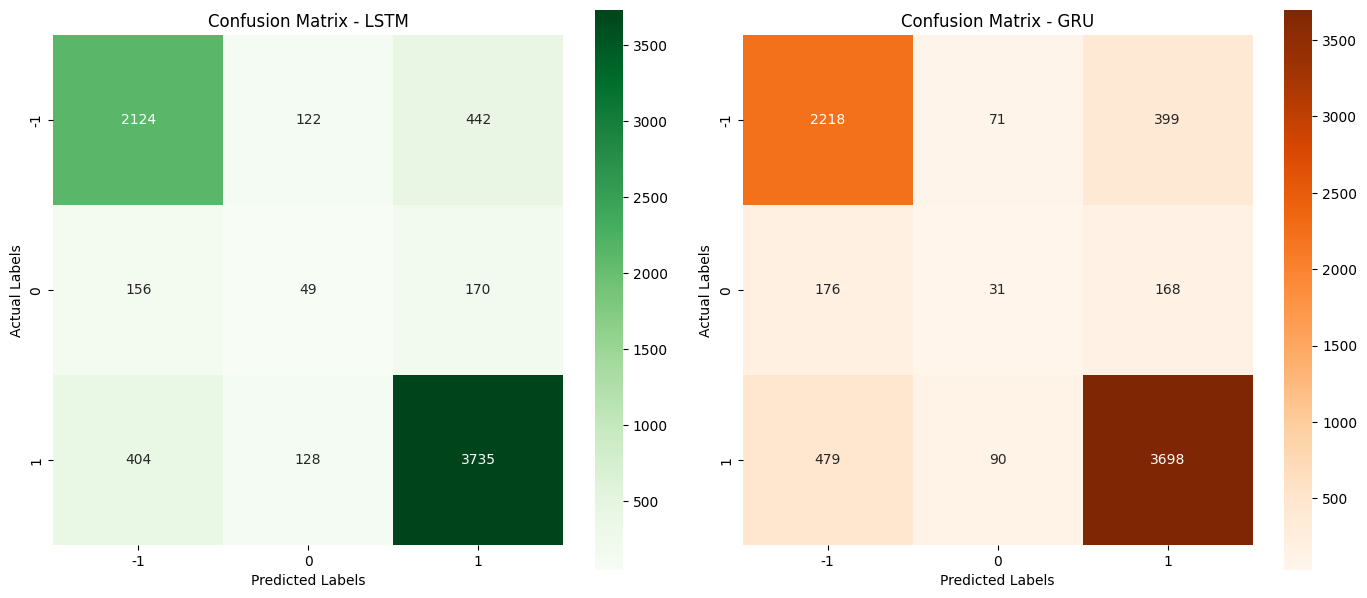

In [37]:
lstm_predicted_ratings = lstm.predict(x_test_padded)
gru_predicted_ratings = gru.predict(x_test_padded)

lstm_predicted_classes = [label_encoder.inverse_transform([np.argmax(score)])[0] for score in lstm_predicted_ratings]
gru_predicted_classes = [label_encoder.inverse_transform([np.argmax(score)])[0] for score in gru_predicted_ratings]

results_lstm_df = pd.DataFrame({
    'Text': x_test,
    'LSTM Prediction': lstm_predicted_classes,
    'Actual Rating': y_test,
})

results_gru_df = pd.DataFrame({
    'Text': x_test,
    'GRU Prediction': gru_predicted_classes,
    'Actual Rating': y_test,
})

confusion_mat_lstm = confusion_matrix(y_test, lstm_predicted_classes)
confusion_mat_gru = confusion_matrix(y_test, gru_predicted_classes)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_mat_lstm, annot=True, fmt='d', cmap='Greens', square=True,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - LSTM')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_mat_gru, annot=True, fmt='d', cmap='Oranges', square=True,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - GRU')

plt.tight_layout()
plt.show()